In [84]:
import numpy as np
import pandas as pd
import gzip
import glob
import sys
import os
from tqdm import tqdm

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../utils/'))))
from utils.preprocess_utils import save_cache
data_path = '/data1/jyhwang/SR/'
file_name = 'Books.csv'
df = pd.read_csv(data_path + file_name)

In [85]:
df_view_org = df.copy()

## Clean Data

In [86]:
df_view = df_view_org
# 2020. 01. 1 부터..
filtered_df = df_view[df_view.timestamp>1483196400000]
#filtered_df = df_view
# 2017. 01. 0.1
1483196400000
# 2020. 0.1 01
1577808061000
#filtered_df = df_view

1577808061000

In [87]:
# User-Item Filtering
item_filter = (filtered_df['parent_asin'].value_counts() >= 10)
filtered_items = filtered_df['parent_asin'].value_counts()[item_filter].index
filtered_df = filtered_df[filtered_df['parent_asin'].isin(filtered_items)]

print("Item Filtering")
print(len(filtered_df))

user_filter = (filtered_df['user_id'].value_counts() >= 5)
filtered_users = filtered_df['user_id'].value_counts()[user_filter].index
filtered_df = filtered_df[filtered_df['user_id'].isin(filtered_users)]

print("User Filtering")
print(len(filtered_df))

# Extract interactions for model training (numpy.ndarray)
uit = filtered_df.loc[:, ['user_id', 'parent_asin', 'timestamp'] ].values
ust = filtered_df.loc[:, ['user_id', 'parent_asin', 'timestamp'] ].values

Item Filtering
2895897
User Filtering
2163798


In [88]:
from utils.preprocess_utils import map_feature_id
num_users,uid_map,uid_rmap = map_feature_id(uit[:,0], str, int)
num_items,iid_map,iid_rmap = map_feature_id(uit[:,1], str, int)
num_time,tid_map,tid_rmap = map_feature_id(sorted(uit[:,2]), str, int) #The mapped timeid should be sorted,
num_state,sid_map,sid_rmap = map_feature_id(ust[:,1], str, int)

In [89]:
from utils.preprocess_utils import build_seq_list
raw_sequences = build_seq_list(uit, uid_map, iid_map, tid_map)#
#raw_state_sequences= build_seq_list(ust, uid_map, sid_map, tid_map)
from utils.preprocess_utils import remove_redundant_items
item_sequences = remove_redundant_items(raw_sequences, raw_sequences)
#state_sequences= remove_redundant_items(raw_state_sequences, raw_state_sequences)

In [90]:
from utils.preprocess_utils import split_seqs
'''
For debugging code.

item_sequences = [[1, 2, 3, 4, 5, 6, 7],
                  [1, 3, 5, 7, 9, 11,1],
                  [2, 4, 2, 6, 8, 9, 4]]

'''



train_seqs, valid_test_seqs = split_seqs(item_sequences,0.8)
valid_seqs, test_seqs = split_seqs(valid_test_seqs,0.5)

seqs = train_seqs
item_pop = [0]*(num_items+1)
for seq in seqs:
    for item in seq:
        item_pop[item] += 1

from utils.preprocess_utils import extract_valid_seqs
train_valid_seqs = list(map(lambda seq: seq[0] + seq[1],
                            zip(train_seqs,valid_seqs)))

valid_seqs, valid_items = extract_valid_seqs(train_seqs, valid_seqs, item_pop)
test_seqs, test_items = extract_valid_seqs(train_valid_seqs, test_seqs, item_pop)

'''
For debugging code.
print(train_seqs)
print(train_valid_seqs)
print("Validation ")
print(valid_seqs)
print(valid_items)
print("Testing")
print(test_seqs)
print(test_items)
'''

from utils.preprocess_utils import generate_pairs_from_sequences
from scipy.sparse import csr_matrix
valid_seen_pairs = np.array(list(generate_pairs_from_sequences(valid_seqs)))
valid_seen_vals = np.ones(len(valid_seen_pairs))
valid_seen_rows = valid_seen_pairs[:,0]
valid_seen_cols = valid_seen_pairs[:,1]
valid_seen_mat = csr_matrix((valid_seen_vals,
                            (valid_seen_rows,
                             valid_seen_cols)), shape = (num_users,num_items))


valid_unseen_pairs = np.array(list(generate_pairs_from_sequences(valid_items)))
valid_unseen_vals = np.ones(len(valid_unseen_pairs))
valid_unseen_rows = valid_unseen_pairs[:,0]
valid_unseen_cols = valid_unseen_pairs[:,1]
valid_unseen_mat = csr_matrix((valid_unseen_vals,
                            (valid_unseen_rows,
                             valid_unseen_cols)), shape = (num_users,num_items))


test_seen_pairs = np.array(list(generate_pairs_from_sequences(test_seqs)))
test_seen_vals = np.ones(len(test_seen_pairs))
test_seen_rows = test_seen_pairs[:,0]
test_seen_cols = test_seen_pairs[:,1]
test_seen_mat = csr_matrix((test_seen_vals,
                            (test_seen_rows,
                             test_seen_cols)), shape = (num_users,num_items))


test_unseen_pairs = np.array(list(generate_pairs_from_sequences(test_items)))
test_unseen_vals = np.ones(len(test_unseen_pairs))
test_unseen_rows = test_unseen_pairs[:,0]
test_unseen_cols = test_unseen_pairs[:,1]
test_unseen_mat = csr_matrix((test_unseen_vals,
                             (test_unseen_rows,
                             test_unseen_cols)), shape = (num_users,num_items))

In [91]:
sorted_pos_lists = [sorted(items) for items in train_seqs] # For efficient negative sampling in training time.
for buck in valid_items:
    if not buck:
        buck.append(-1)
for buck in test_items:
    if not buck:
        buck.append(-1)

In [92]:
print("num_users:%s num_items:%s"%(num_users,num_items))

num_users:186054 num_items:90537


In [93]:
from utils.preprocess_utils import save_cache
objs = {
    "num_users": num_users,
    "num_items": num_items,
    "train_seqs": train_seqs,
    "valid_seqs": valid_seqs,
    "test_seqs": test_seqs,
    "valid_items": valid_items,
    "test_items": test_items,
    "valid_seen_mat": valid_seen_mat,
    "valid_gt_mat": valid_unseen_mat,
    "test_seen_mat": test_seen_mat,
    "test_gt_mat": test_unseen_mat,
    "sorted_pos_lists": sorted_pos_lists,
    "item_pop":item_pop
}
save_cache(data_path,'Books_cache',objs)

In [94]:
from collections import Counter
import torch

In [95]:
valid_items = torch.LongTensor(valid_items).flatten()

In [96]:
valid_dict = Counter(valid_items.cpu().numpy())

In [97]:
valid_dict

Counter({-1: 50276,
         5: 4,
         23: 16,
         62: 2,
         74: 1,
         84: 1,
         92: 52,
         122: 2,
         140: 1,
         152: 1,
         169: 3,
         317: 1,
         370: 1,
         387: 1,
         451: 1,
         475: 1,
         495: 1,
         504: 5,
         537: 3,
         568: 9,
         581: 1,
         592: 4,
         657: 1,
         690: 65,
         700: 4,
         714: 2,
         733: 4,
         786: 5,
         982: 3,
         1029: 7,
         1058: 3,
         1114: 1,
         1138: 3,
         1148: 1,
         1156: 2,
         1184: 4,
         1194: 2,
         1207: 10,
         1224: 2,
         1306: 4,
         1352: 2,
         1517: 3,
         1560: 2,
         1595: 7,
         1722: 7,
         1763: 1,
         1780: 2,
         1795: 3,
         1802: 3,
         1814: 5,
         1896: 3,
         1944: 6,
         1978: 1,
         1998: 13,
         2073: 5,
         2095: 3,
         2109: 1,
  

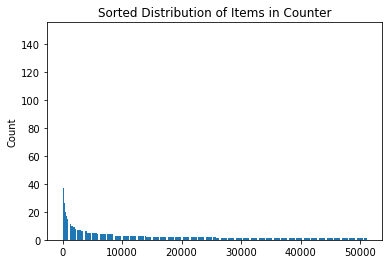

In [99]:
data = sorted_values

# Calculate the KDE
kde = gaussian_kde(data, bw_method='silverman')
kde_x = np.linspace(min(data), max(data), 500)
kde_y = kde(kde_x)

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.5, color='blue', edgecolor='black')

# Plot KDE
plt.plot(kde_x, kde_y, color='red')

# Show the plot
plt.show()

51093

In [101]:
valid_dict[-1]

0